<a href="https://colab.research.google.com/github/jma52799/fake-jobs-ml/blob/main/fakejobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import io
import json
import tensorflow as tf
import os
import pathlib
from pathlib import Path
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense,LSTM,GRU,Embedding,Dropout
from keras.models import Sequential
from keras.models import Sequential
from datetime import date
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from os.path import exists


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Data Understanding

In [ ]:
jobs_df= pd.read_csv("/content/job_postings.csv", on_bad_lines='skip')
print(" Shape of Jobs data: ", jobs_df.shape)
print("")
print(" Jobs data info: ", jobs_df.info())

 Shape of Jobs data:  (17880, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry          

 Number of Null values in each column: 
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

 Fradulent value counts: 
fraudulent
0    17014
1      866
Name: count, dtype: int64


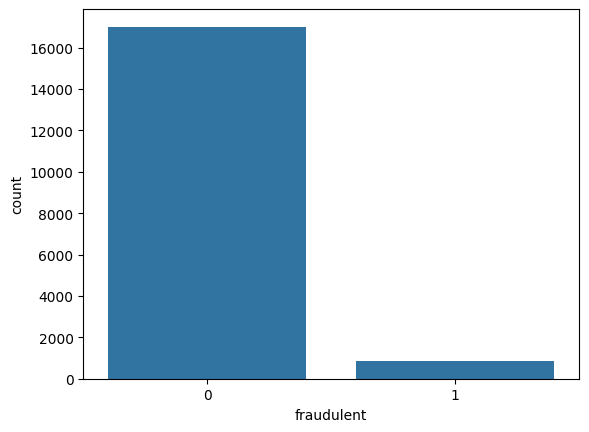

In [ ]:
print(" Number of Null values in each column: ")
print(jobs_df.isnull().sum())
print("")
print(" Fradulent value counts: ")
print(jobs_df['fraudulent'].value_counts())
sns.countplot(x="fraudulent", data=jobs_df);
plt.show()

# Clean Dataset

In [ ]:
#Constants used for cleaning the datasets
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
remove_columns = ['job_id', 'location']
non_text_columns_with_null = ['department', 'salary_range', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
categorical_columns = []
target_col = ['fraudelent']


In [ ]:
## Clean Datasets
wnl = nltk.stem.WordNetLemmatizer()
stopwords_dict = set(stopwords.words('english'))

# Removed unused clumns
def remove_unused_columns(df,column_names=remove_columns):
    df = df.drop(column_names,axis=1)
    return df

# Impute null values with "" for text columns
def null_processing_text_columns(df):
    for col in text_columns:
        df.loc[df[col].isnull(), col] = ""
    return df

def null_process(df):
    df.fillna("", inplace=True)
    return df

# Impute null values with "None" for non-text columns
def null_processing(df):
    for col in non_text_columns_with_null:
        df.loc[df[col].isnull(), col] = "None"
    return df


def clean_datasets(df):
    # remove unused column
    df = remove_unused_columns(df)
    #drop rows with null value in the 'fraudulent' column
    df = df.dropna(axis=0, subset=['fraudulent'])

    df = null_process(df)
    #impute null values for non-text columns
    #df = null_processing(df)
    #impute null values for text columns
    #df = null_processing_text_columns(df)
    return df

df = clean_datasets(jobs_df)

print(df.shape)

(17880, 16)


#Merge Text Data


In [ ]:
# Merge text columns together
def merge_text_columns(df, columns=text_columns):
    df['text'] = df[text_columns].apply(lambda x: ' '.join(x), axis=1)
    return df

In [ ]:
df = merge_text_columns(df, text_columns)

# Explorative Data Analysis

###Top 20 trigram for fake jobs

In [ ]:
true_jobs = ' '.join(df[df['fraudulent']==0]['text'])
fake_jobs = ' '.join(df[df['fraudulent']==1]['text'])

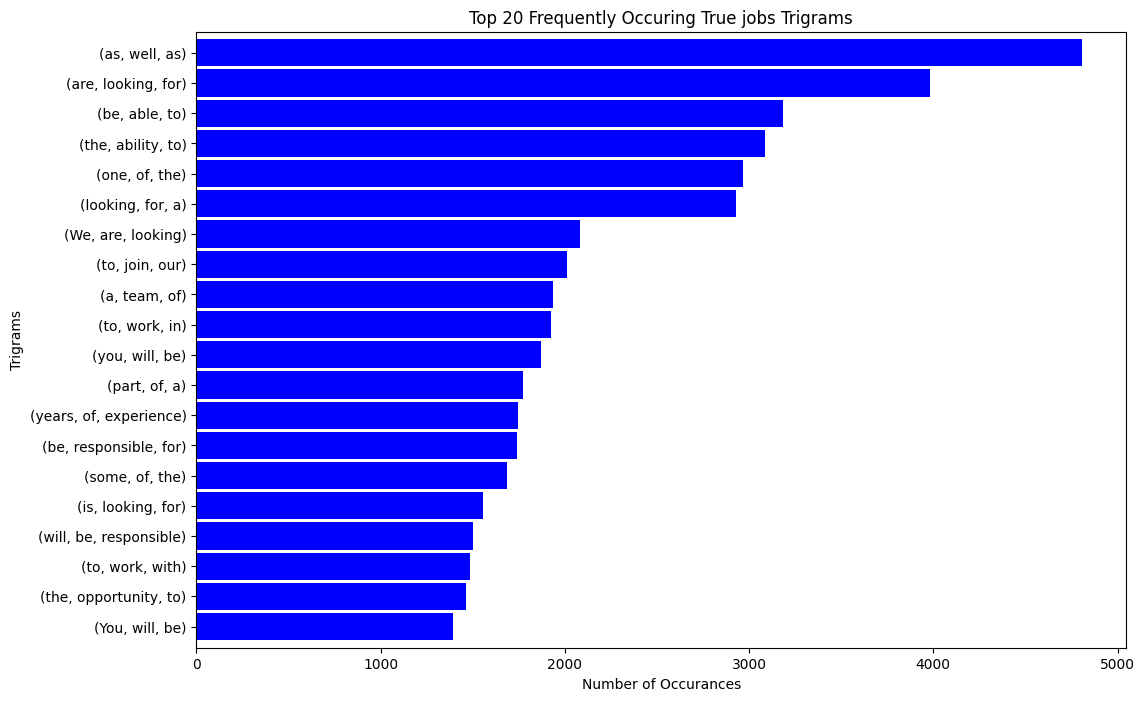

In [ ]:
true_trigrams = (pd.Series(nltk.ngrams(true_jobs.split(), 3)).value_counts())[:20]
true_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring True jobs Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Number of Occurances')
plt.show()

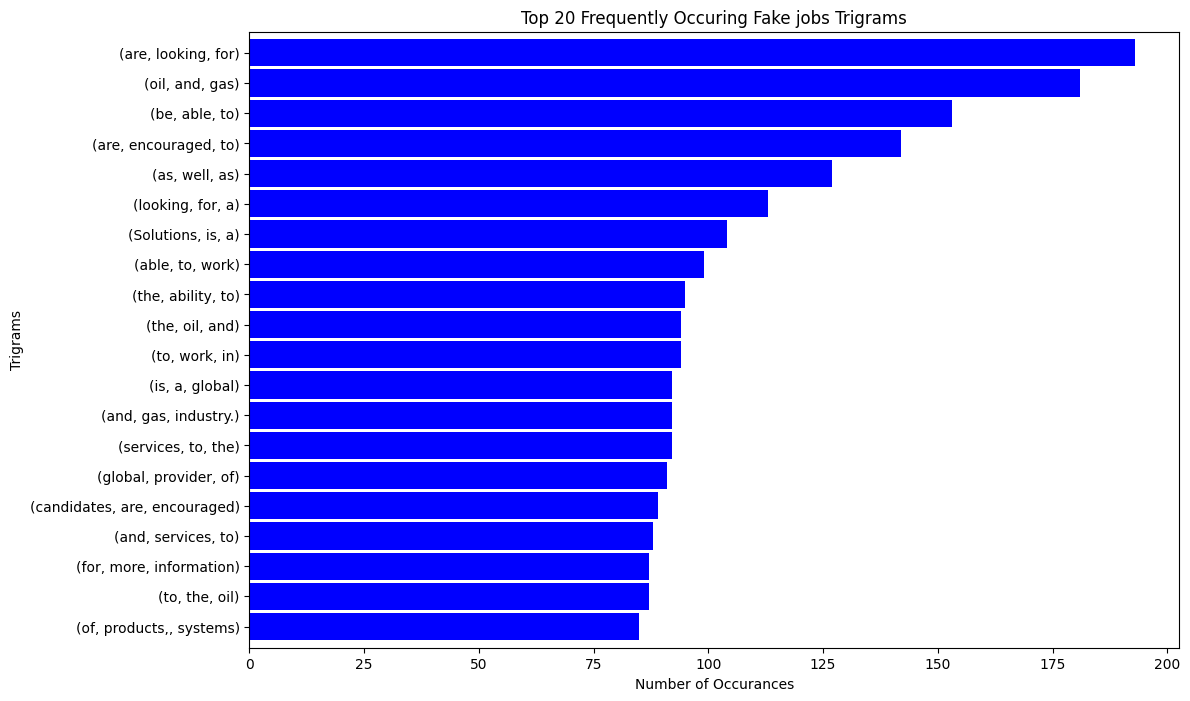

In [ ]:
false_trigrams = (pd.Series(nltk.ngrams(fake_jobs.split(), 3)).value_counts())[:20]
false_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('Top 20 Frequently Occuring Fake jobs Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Number of Occurances')
plt.show()

# NLTK PreProcessing

In [ ]:
## Nltk Preprocessing include:
# Stop words,
# Stemming and
# Lemmetization
# For my project I used Stop word removal and Lemmetization
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)  # removing urls
    text = re.sub(r'#URL_[\w\d]+#', ' ', text)  # Remove strings that start with 'URL_' and are enclosed by '#'
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = [wnl.lemmatize(word) for word in text.split() if word not in stopwords_dict]
    #return ' '.join(text)
    return text

In [ ]:
df['text'] = df['text'].apply(lambda x: preprocess_text(x))

df.head()

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,Marketing Intern,Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,"[marketing, intern, food, weve, created, groun..."
1,Customer Service - Cloud Video Production,Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,"[customer, service, cloud, video, production, ..."
2,Commissioning Machinery Assistant (CMA),,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,"[commissioning, machinery, assistant, cma, val..."
3,Account Executive - Washington DC,Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,"[account, executive, washington, dc, passion, ..."
4,Bill Review Manager,,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,"[bill, review, manager, spotsource, solution, ..."


#Split Data into Train and Test set

In [ ]:
X = df['text']
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Text Tokenizer


1.   Initialize and fit tokenizer
2.   Convert text to sequences
3.   Pad sequence to ensure uniform length

## Find the optimal vocab size

In [ ]:
# Fit the tokenizer on your training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Get the word index
word_index = tokenizer.word_index
print(f"Total unique words: {len(word_index)}")

Total unique words: 136213


In [ ]:
# Get word counts
word_counts = tokenizer.word_counts

# Sort the words by frequency
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

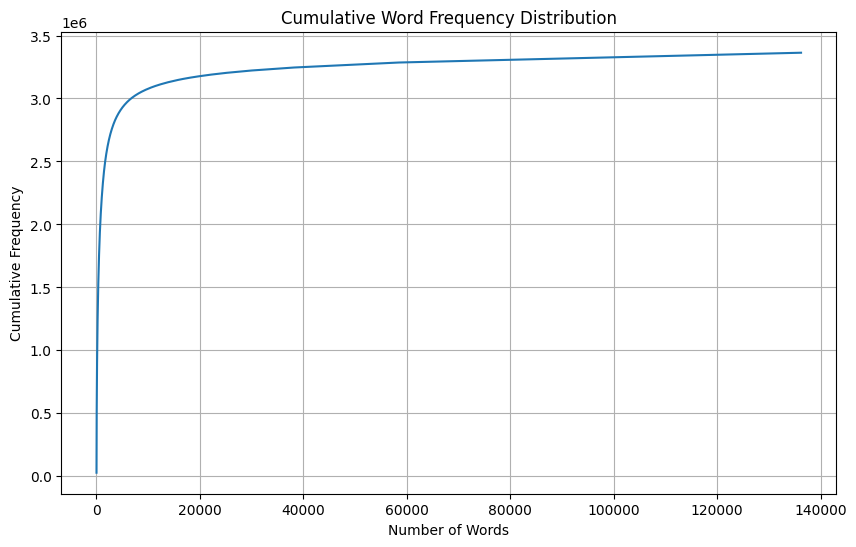

In [ ]:
# Calculate cumulative frequency distribution
cumulative_counts = [count for word, count in sorted_word_counts] #collects the count of each unique word
cumulative_counts = [sum(cumulative_counts[:i+1]) for i in range(len(cumulative_counts))]

# Plot the cumulative frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_counts)+1), cumulative_counts)
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Word Frequency Distribution')
plt.grid(True)
plt.show()

In [ ]:
# Calculate total word count
total_word_count = cumulative_counts[-1]

# Find the smallest number of words that cover 90% of the total word usage
threshold = 0.90 * total_word_count
vocab_size = next(i for i, count in enumerate(cumulative_counts) if count > threshold) + 1
print(f"Vocabulary size covering 90% of the total word usage: {vocab_size}")

Vocabulary size covering 90% of the total word usage: 7601


## Actual Sequence Data Transformation

In [ ]:
oov_token = "<OOV>"
max_text_length = 400
vocab_size = 20000

# Save the tokenizer
def save_tokenizer(tokenizer, num_words = vocab_size):
    os.makedirs('./models/', exist_ok=True)
    filepath = './models/' + 'tokenizer_' + str(num_words) + '.json'
    with io.open(filepath, 'w', encoding='utf-8') as outfile:
        outfile.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))
    outfile.close()
    return

# Initialize and fit the tokenizer with the determined vocab_size
tokenizer = Tokenizer(oov_token = oov_token, num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
save_tokenizer(tokenizer)

def sequence_data_transformation(texts, tokenizer):
  # Convert texts to sequences
  sequences = tokenizer.texts_to_sequences(texts)
  return sequences

def pad_sequences_data(sequences, max_text_length):
  # Pad sequences to ensure uniform length
  padded_sequences = pad_sequences(sequences, maxlen=max_text_length, padding='post')
  return padded_sequences

In [ ]:
train_text_seq = sequence_data_transformation(X_train,tokenizer)
test_text_seq = sequence_data_transformation(X_test,tokenizer)

train_text_padded = pad_sequences_data(train_text_seq,max_text_length)
test_text_padded = pad_sequences_data(test_text_seq,max_text_length)

In [ ]:
print(train_text_padded.shape)
print(test_text_padded.shape)
print(y_train.shape)
print(y_test.shape)

(14304, 400)
(3576, 400)
(14304,)
(3576,)


# Feature Engineering

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=6cd8b36e81f0f7ac3938c8dc2e23096f82751567b963c3f6f6eaf6da8186a1a2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget

# Define constants for word embeddings
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_DIR = "./glove/"
GLOVE_ZIP_FILE = os.path.join(GLOVE_DIR, "glove.6B.zip")
GLOVE_FILE_PATH = os.path.join(GLOVE_DIR, "glove.6B.100d.txt")  # Adjust based on the dimensions you need

def extractGlovefile(glove_dir=GLOVE_DIR, glove_url=GLOVE_URL):
    os.makedirs(glove_dir, exist_ok=True)
    file_zip = pathlib.Path(glove_dir + "glove.6B.zip")
    if file_zip.exists():
        with ZipFile(glove_dir + 'glove.6B.zip', 'r') as zip:
            zip.printdir()
            zip.extractall(glove_dir)
    else:
        print("glove pretrained model not exists..downloading start..")
        wget.download(glove_url, out=glove_dir)
        with ZipFile(glove_dir + 'glove.6B.zip', 'r') as zip:
            zip.printdir()
            zip.extractall(glove_dir) #extracting the files


extractGlovefile()

glove pretrained model not exists..downloading start..
File Name                                             Modified             Size
glove.6B.50d.txt                               2014-08-04 13:15:00    171350079
glove.6B.100d.txt                              2014-08-04 13:14:34    347116733
glove.6B.200d.txt                              2014-08-04 13:14:44    693432828
glove.6B.300d.txt                              2014-08-27 12:19:16   1037962819


In [ ]:
VOCAB_SIZE = 20000
EMB_DIM = 100
MAX_TEXT_LENGTH = 400

In [ ]:
# Function to read GloVe embeddings
def read_glove_embeddings(glove_file_path=GLOVE_FILE_PATH):
    # Read GloVe embeddings into a DataFrame
    # used read_table before now read_csv
    word_vec = pd.read_csv(glove_file_path, sep=r"\s", header=None, engine='python', encoding='iso-8859-1', on_bad_lines='skip')
    word_vec.set_index(0, inplace=True)
    print('Found %s word vectors.' % len(word_vec))
    return word_vec

In [ ]:
# Function to create the embedding matrix
def glove_embeddings(tokenizer, embeddings_index, vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM):
    embedding_matrix = np.zeros((vocab_size, emb_dim))

    index_n_word = [(i, tokenizer.index_word[i]) for i in range(1, vocab_size) if tokenizer.index_word[i] in embeddings_index.index]
    idx, word = zip(*index_n_word)
    embedding_matrix[list(idx), :] = embeddings_index.loc[list(word), :].values

    return embedding_matrix

In [ ]:
def build_embeddings(tokenizer, vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, max_text_length=MAX_TEXT_LENGTH):

    embeddings_index = read_glove_embeddings()
    embedding_matrix = glove_embeddings(tokenizer, embeddings_index, vocab_size, emb_dim)
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_text_length,
                                weights=[embedding_matrix], trainable=False)

    return embedding_layer

In [ ]:
embedding_layer = build_embeddings(tokenizer)

Found 399823 word vectors.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Model building, training, and evaluation

In [ ]:
def build_lstm(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def build_gru(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def plot_training_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
def model_evaluation(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_training_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def model_evaluation(model, X_test, y_test):
    return model.evaluate(X_test, y_test)


def performance_report(model, X_test, y_test, model_name, type, report_dir='./reports/'):
    os.makedirs('./reports/', exist_ok=True)

    #time = date.today()
    time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # predict probabilities for test set
    yhat_probs = model.predict(X_test, verbose=0)

    # predict crisp classes for test set
    #yhat_classes = model.predict_classes(X_test, verbose=0)
    yhat_classes = (model.predict(X_test) > 0.5).astype("int32")

    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)

    if exists(report_dir + 'report.csv'):
        df = pd.read_csv(report_dir + 'report.csv')
    else:
        df = pd.DataFrame(columns=['time', 'model_name', 'type', 'accuracy', 'precision', 'recall', 'f1'])

    new_row = pd.DataFrame({
      'time': [time],
      'model_name': [model_name],
      'type': [type],
      'accuracy': [accuracy],
      'precision': [precision],
      'recall': [recall],
      'f1': [f1]
    })

    df = pd.concat([df, new_row], ignore_index=True)

    df.to_csv(report_dir + 'report.csv', index=False)
    return df

In [ ]:
def save_model_to_file(model, model_name, index, output_dir='./models/'):
    os.makedirs('./models/', exist_ok=True)

    # Model file names
    json_file_path = os.path.join(output_dir, f'{model_name}_{index}.json')
    h5_file_path = os.path.join(output_dir, f'{model_name}_{index}.weights.h5')

    # Save model architecture as JSON
    model_json = model.to_json()
    with open(json_file_path, 'w') as json_file:
        json_file.write(model_json)

    # Save model weights as HDF5
    model.save_weights(h5_file_path)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9329 - loss: 0.4532 - val_accuracy: 0.9535 - val_loss: 0.1890
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9501 - loss: 0.2033 - val_accuracy: 0.9535 - val_loss: 0.1861
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9501 - loss: 0.2018 - val_accuracy: 0.9535 - val_loss: 0.1856
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9521 - loss: 0.1949 - val_accuracy: 0.9535 - val_loss: 0.1854
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9536 - loss: 0.1909 - val_accuracy: 0.9535 - val_loss: 0.1840
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9493 - loss: 0.1996 - val_accuracy: 0.9535 - val_loss: 0.1834
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9504 - loss: 0.1975 - val_accuracy: 0.9535 - val_loss: 0.1915
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9555 - loss: 0.1860 - val_accuracy: 0.9539 - v

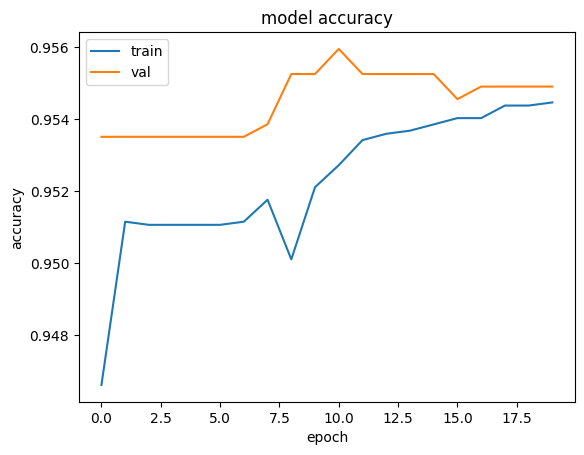

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.955537
Precision: 0.937500
Recall: 0.086705
F1 score: 0.158730


<ipython-input-83-f24f0c91ba03>:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


,time,model_name,type,accuracy,precision,recall,f1
0,2024-08-02 20:08:33,lstm,train,0.955537,0.9375,0.086705,0.15873


In [ ]:
model_lstm = build_lstm(embedding_layer)
history = model_lstm.fit(train_text_padded, y_train, epochs=20, batch_size=256, validation_split=0.2)
plot_training_history(history)
save_model_to_file(model_lstm, 'lstm', 1)
# accuracy_score = model_evaluation(model_lstm, test_text_padded, y_test)
performance_report(model_lstm, test_text_padded, y_test, 'lstm', 'train')

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9496 - loss: 0.4733 - val_accuracy: 0.9535 - val_loss: 0.1848
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9548 - loss: 0.1875 - val_accuracy: 0.9553 - val_loss: 0.1822
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9510 - loss: 0.1984 - val_accuracy: 0.9556 - val_loss: 0.1822
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9550 - loss: 0.1871 - val_accuracy: 0.9553 - val_loss: 0.1822
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9505 - loss: 0.1978 - val_accuracy: 0.9553 - val_loss: 0.1819
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9540 - loss: 0.1882 - val_accuracy: 0.9553 - val_loss: 0.1823
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9550 - loss: 0.1872 - val_accuracy: 0.9546 - val_loss: 0.1845
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9519 - loss: 0.1950 - val_accuracy: 0.9553 - v

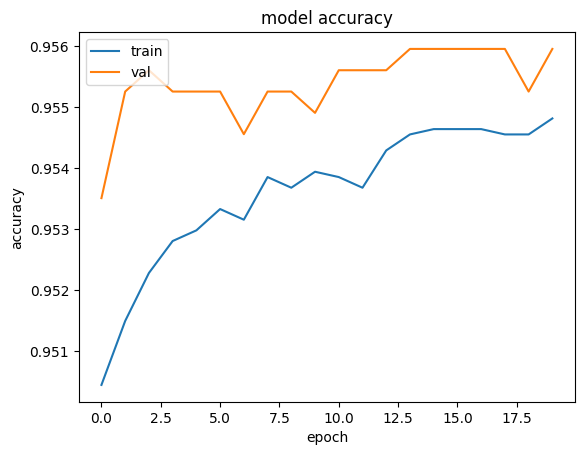

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy: 0.954698
Precision: 0.866667
Recall: 0.075145
F1 score: 0.138298


,time,model_name,type,accuracy,precision,recall,f1
0,2024-08-02 20:08:33,lstm,train,0.955537,0.937500,0.086705,0.158730
1,2024-08-02 20:09:25,gru,train,0.954698,0.866667,0.075145,0.138298


In [ ]:
model_gru = build_gru(embedding_layer)
history = model_gru.fit(train_text_padded, y_train, epochs=20, batch_size=256, validation_split=0.2)
plot_training_history(history)
save_model_to_file(model_gru, 'gru', 1)
performance_report(model_gru, test_text_padded, y_test, 'gru', 'train')